In [15]:
from goatools import obo_parser
from scipy.stats import hypergeom

import os
import sys
import numpy as np
import pandas as pd
import networkx as nx

In [16]:
M = np.arange(15).reshape(5,3)

In [17]:
(M.T / M.sum(axis=1)).T

array([[0.        , 0.33333333, 0.66666667],
       [0.25      , 0.33333333, 0.41666667],
       [0.28571429, 0.33333333, 0.38095238],
       [0.3       , 0.33333333, 0.36666667],
       [0.30769231, 0.33333333, 0.35897436]])

In [18]:
DATA_DIRECTORY = "/media/clusterduck123/joe/data"
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed_data/yeast"
ANNOTATION_DIRECTORY = f"{YEAST_DIRECTORY}/annotations"

RUN = 0
MIN_CLUSTERS = 40
MAX_CLUSTERS = 50

In [19]:
network = 'systematic_CoEx_COEXPRESdb'
feature = 'GDV'
metric = 'canberra'
method = 'kmedoid'
aspect = 'BP'

In [4]:
CLUSTER_DIRECTORY = f"{YEAST_DIRECTORY}/clusterings/{network}/{feature}/{metric}/{method}"
PVALUE_DIRECTORY  = f"{YEAST_DIRECTORY}/pvalues/{network}/{feature}/{metric}/{method}/{aspect}"

G_nx = nx.read_edgelist(f"{YEAST_DIRECTORY}/networks/{network}.txt")
annotation_df = pd.read_csv(f"{ANNOTATION_DIRECTORY}/GO_{aspect}_systematic_SGD.csv")
annotation_df = annotation_df[annotation_df.Systematic_ID.isin(G_nx)]
go_dag = obo_parser.GODag(f"{RAW_DATA_DIRECTORY}/go-basic.obo")

GO_population = set(annotation_df.GO_ID)

# Conversion dictionaries
GO2genes = pd.Series({go_id: set(genes.Systematic_ID)
                        for go_id, genes in annotation_df.groupby('GO_ID')},
                     name='nb_genes')

gene2GO  = {gene : set(go_ids.GO_ID) for gene, go_ids in annotation_df.groupby('Systematic_ID')}
global_GO_counter = GO2genes.apply(len)

for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    with open(f"{CLUSTER_DIRECTORY}/{RUN}_{n_clusters}.txt", 'r') as f:
         cluster_list = [set(line.split()) for line in f]
    cluster_df = pd.Series({gene:cluster_idx
                                for cluster_idx,cluster in enumerate(cluster_list)
                                for gene in cluster})

    n_annotated_genes_in_cluster = pd.DataFrame(np.array(
            [ [len(go_genes & cluster) for cluster in cluster_list] for go_genes in GO2genes]),
                                               index   = GO2genes.index,
                                               columns = range(n_clusters))


    k = n_annotated_genes_in_cluster

    K = pd.concat([global_GO_counter[GO2genes.index]]*n_clusters, axis=1)
    K.columns = k.columns

    n = pd.concat([pd.DataFrame(map(len, cluster_list)).T]*len(GO2genes))
    n.index = k.index

    N = pd.DataFrame(len(G_nx), columns=k.columns, index=k.index)

    assert K.eq(k.sum(axis=1), axis=0).all().all()
    assert N.eq(n.sum(axis=1), axis=0).all().all()

    # scipy has a really messed up nomeclature...
    p_values = pd.DataFrame(1-hypergeom.cdf(k=k.values-1,
                                            M=N.values,
                                            N=n.values,
                                            n=K.values),
                            index=GO2genes.index)
    p_values.to_csv(f"{PVALUE_DIRECTORY}/{RUN}_{n_clusters}.txt")

/media/clusterduck123/joe/data/raw_data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [31]:
annotation_df = pd.read_csv(f"{ANNOTATION_DIRECTORY}/GO_{aspect}_systematic_SGD.csv")

In [34]:
annotation_df[annotation_df.Systematic_ID.isin(G_nx)]

,Systematic_ID,GO_ID,Level
0,YDL159W,GO:0043405,7
1,YDL159W,GO:0065007,1
2,YDL159W,GO:0010604,5
3,YDL159W,GO:0065009,2
4,YDL159W,GO:0019220,6
...,...,...,...
170056,YDR266C,GO:0051171,4
170057,YDR266C,GO:0017148,7
170058,YDR266C,GO:0031326,5
170059,YDR266C,GO:0032269,6


In [23]:
GO2genes['GO:0001196']

{'YCR039C', 'YCR084C', 'YMR043W'}

In [20]:
K[K[0] != k.sum(axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
GO:0000122,145,145,145,145,145,145,145,145,145,145,...,145,145,145,145,145,145,145,145,145,145
GO:0000722,32,32,32,32,32,32,32,32,32,32,...,32,32,32,32,32,32,32,32,32,32
GO:0000723,74,74,74,74,74,74,74,74,74,74,...,74,74,74,74,74,74,74,74,74,74
GO:0000750,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
GO:0001196,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2000112,696,696,696,696,696,696,696,696,696,696,...,696,696,696,696,696,696,696,696,696,696
GO:2000113,299,299,299,299,299,299,299,299,299,299,...,299,299,299,299,299,299,299,299,299,299
GO:2000241,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
GO:2000243,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51


In [30]:
for nr, cluster in enumerate(cluster_list):
    genes = cluster & {'YCR039C', 'YCR084C', 'YMR043W'}
    if genes:
        print(nr, genes)

26 {'YMR043W'}
34 {'YCR084C'}


In [25]:
k.loc['GO:0001196']

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    1
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    1
35    0
36    0
37    0
38    0
39    0
Name: GO:0001196, dtype: int64

In [22]:
k[K[0] != k.sum(axis=1)].sum(axis=1)

GO:0000122    144
GO:0000722     26
GO:0000723     68
GO:0000750     22
GO:0001196      2
             ... 
GO:2000112    693
GO:2000113    297
GO:2000241    100
GO:2000243     50
GO:2001141    538
Length: 244, dtype: int64

In [8]:
networks    = {'systematic_PPI_BioGRID'}

In [10]:
eval(line.strip())

SyntaxError: invalid syntax (<string>, line 1)

In [1]:
from scipy.spatial.distance import squareform, cdist
from scipy.spatial.distance import pdist
from scipy.integrate import quad
from itertools import combinations, product, combinations_with_replacement
from functools import partial
from goatools import obo_parser

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import scipy
import graco
import time
import os

In [2]:
DATA_DIRECTORY = "/media/clusterduck123/joe/data"
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw-data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed_data/yeast"
NETWORK_DIRECTORY = f"{YEAST_DIRECTORY}/networks"
ANNOTATION_DIRECTORY = f"{YEAST_DIRECTORY}/annotations"
MATRIX_DIRECTORY  = f"{YEAST_DIRECTORY}/distance_matrices"

In [3]:
aspect  = 'BP'
network = 'systematic_CoEx_COEXPRESdb' 

PPI = nx.read_edgelist(f"{NETWORK_DIRECTORY}/{network}.txt")
annotation_df = pd.read_csv(f"{ANNOTATION_DIRECTORY}/GO_{aspect}_BioGRID-SGD.csv")
go_dag = obo_parser.GODag(f"{RAW_DATA_DIRECTORY}/go-basic.obo")

gene_population = set(PPI.nodes())
GO_population = set(annotation_df.GO_ID)

/media/clusterduck123/joe/data/raw-data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [4]:
# Conversion dictionaries
GO2genes = pd.Series({go_id: set(genes.Systematic_ID) for go_id, genes in annotation_df.groupby('GO_ID')}, 
                     name='nb_genes')

gene2GO  = {gene : set(go_ids.GO_ID) for gene, go_ids in annotation_df.groupby('Systematic_ID')}
global_GO_counter = GO2genes.apply(len)

In [20]:
with open('/home/clusterduck123/Desktop/GOtermsBiologicalProcess.csv') as f:
    f.readline()
    GO_list = {line.strip() for line in f}

In [29]:
with open("/home/clusterduck123/Desktop/git/graco/scripts/input_parameters.py") as f:
    content = f.readlines()

In [32]:
content[0]

"networks    = {'systematic_PPI_BioGRID'}\n"

In [28]:
np.savetxt("/home/clusterduck123/Desktop/lol.txt", a)

In [22]:
GO_population-GO_list

{'GO:1901568',
 'GO:0000272',
 'GO:0071826',
 'GO:0019218',
 'GO:1904031',
 'GO:0051051',
 'GO:0010383',
 'GO:0080134',
 'GO:0043068',
 'GO:0043039',
 'GO:0098732',
 'GO:0051510',
 'GO:0046218',
 'GO:1902100',
 'GO:0009059',
 'GO:0031032',
 'GO:0071941',
 'GO:0034470',
 'GO:0071398',
 'GO:0046483',
 'GO:0032881',
 'GO:0046364',
 'GO:0032951',
 'GO:0006022',
 'GO:2000781',
 'GO:0044784',
 'GO:0051098',
 'GO:0046365',
 'GO:0032988',
 'GO:0006739',
 'GO:0032989',
 'GO:0046999',
 'GO:0009266',
 'GO:1905898',
 'GO:1903729',
 'GO:0032092',
 'GO:0022402',
 'GO:0071709',
 'GO:0051403',
 'GO:0009185',
 'GO:0044264',
 'GO:0036260',
 'GO:0031023',
 'GO:0046903',
 'GO:0046174',
 'GO:0006091',
 'GO:1901033',
 'GO:0006082',
 'GO:0070304',
 'GO:0046080',
 'GO:0072511',
 'GO:1902475',
 'GO:0070785',
 'GO:0007187',
 'GO:0001120',
 'GO:0031061',
 'GO:0033043',
 'GO:0140029',
 'GO:0009309',
 'GO:1900187',
 'GO:0051248',
 'GO:0030832',
 'GO:0035510',
 'GO:0010638',
 'GO:0035372',
 'GO:1903008',
 'GO:00988

In [23]:
GO2genes['GO:1901568']

{'YMR246W', 'YOR317W'}

In [5]:
G = nx.barabasi_albert_graph(2**8,2)
GCV = graco.coefficients(G)

In [6]:
feature_matrix = GCV[['D','A','G']].drop(('G','0-0'), axis=1)

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
feature_matrix.T.head(50)

0         1         2         3         4    \
Group Equation Orbit                                                     
D     0        2      0.969758  0.900000  0.984496  0.952632  0.967033   
               3      0.030242  0.100000  0.015504  0.047368  0.032967   
      1        10     0.057789  0.216102  0.032168  0.107212  0.094017   
               12     0.002760  0.008475  0.000760  0.004678  0.000000   
               5      0.922891  0.775424  0.950355  0.874074  0.876068   
               8      0.016560  0.000000  0.016717  0.014035  0.029915   
      2        11     0.057103  0.222222  0.029960  0.085942  0.064394   
               13     0.001317  0.000000  0.000384  0.003376  0.000947   
               7      0.941580  0.777778  0.969656  0.910681  0.934659   
      3        11     0.915556  1.000000  0.951220  0.864198  0.944444   
               13     0.084444  0.000000  0.048780  0.135802  0.055556   
               14     0.000000  0.000000  0.000000  0.000000  0.000000   
A     0        1      0.861751  0.967213  0.870370  0.882353  0.923077   
               3      0.138249  0.032787  0.129630  0.117647  0.076923   
      1        10     0.355626  0.174061  0.265690  0.373641  0.180698   
               13     0.040340  0.000000  0.029289  0.029891  0.004107   
               4      0.502123  0.825939  0.566946  0.547554  0.757700   
               8      0.101911  0.000000  0.138075  0.048913  0.057495   
      2        10     0.189480  0.054957  0.228417  0.176735  0.097023   
               13     0.010747  0.000000  0.012590  0.007069  0.001103   
               6      0.799774  0.945043  0.758993  0.816195  0.901874   
      3        12     0.695652  0.133333  0.272727  0.444444  0.000000   
               14     0.000000  0.000000  0.000000  0.000000  0.000000   
               9      0.304348  0.866667  0.727273  0.555556  1.000000   
G     1-1      12     0.026711  0.007407  0.008427  0.024948  0.000000   
               4      0.789649  0.896296  0.761236  0.837838  0.868235   
               8      0.160267  0.000000  0.185393  0.074844  0.065882   
               9      0.023372  0.096296  0.044944  0.062370  0.065882   
      1-2      10     0.104917  0.027823  0.128283  0.096255  0.050228   
               12     0.005011  0.001091  0.003030  0.004200  0.000000   
               6      0.885687  0.956901  0.852525  0.889044  0.933790   
               9      0.004385  0.014184  0.016162  0.010501  0.015982   
      2-1      11     0.130628  0.031746  0.124714  0.108527  0.074074   
               13     0.006024  0.000000  0.003198  0.008527  0.002179   
               5      0.848129  0.968254  0.857012  0.868992  0.893246   
               8      0.015219  0.000000  0.015075  0.013953  0.030501   
      3-3      10     0.861183  0.962264  0.881944  0.889968  0.977778   
               12     0.041131  0.037736  0.020833  0.038835  0.000000   
               13     0.097686  0.000000  0.097222  0.071197  0.022222   
               14     0.000000  0.000000  0.000000  0.000000  0.000000   

                           5         6         7         8         9    ...  \
Group Equation Orbit                                                    ...   
D     0        2      0.933333  0.970588  0.904762  0.955556  0.972222  ...   
               3      0.066667  0.029412  0.095238  0.044444  0.027778  ...   
      1        10     0.154545  0.077922  0.171053  0.137328  0.010937  ...   
               12     0.006061  0.004870  0.004386  0.004994  0.000000  ...   
               5      0.815152  0.904221  0.793860  0.845194  0.967187  ...   
               8      0.024242  0.012987  0.030702  0.012484  0.021875  ...   
      2        11     0.142857  0.054545  0.168421  0.081395  0.057143  ...   
               13     0.000000  0.001515  0.010526  0.002907  0.000000  ...   
               7      0.857143  0.943939  0.821053  0.915698  0.942857  ...   
      3        11     1.000000  0.900000  0.80000

In [4]:
feature_matrix.sort_index()

Group            D                                                    \
Equation         0                   1                                 
Orbit            2         3        10        12         5         8   
0         0.982456  0.017544  0.050287  0.001916  0.926724  0.021073   
1         0.970443  0.029557  0.062299  0.003759  0.918904  0.015038   
2         0.987692  0.012308  0.035130  0.000696  0.944000  0.020174   
3         0.966667  0.033333  0.068659  0.001166  0.914723  0.015452   
4         0.974713  0.025287  0.079526  0.002155  0.903233  0.015086   
..             ...       ...       ...       ...       ...       ...   
251       0.000000  1.000000  0.921569  0.078431  0.000000  0.000000   
252       1.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
253       1.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
254       1.000000  0.000000  0.000000  0.000000  0.955556  0.044444   
255       0.000000  1.000000  0.774194  0.225806  0.000000  0.000000   

Group                                             ...         G            \
Equation         2                             3  ...       1-2             
Orbit           11        13         7        11  ...         6         9   
0         0.034314  0.000350  0.965336  0.960784  ...  0.926735  0.020378   
1         0.057154  0.000940  0.941906  0.938272  ...  0.901288  0.010730   
2         0.023364  0.000389  0.976246  0.937500  ...  0.903371  0.019476   
3         0.061431  0.001884  0.936685  0.890756  ...  0.848972  0.008341   
4         0.041442  0.002611  0.955947  0.798701  ...  0.861102  0.013857   
..             ...       ...       ...       ...  ...       ...       ...   
251            NaN       NaN       NaN       NaN  ...  0.945594  0.015326   
252            NaN       NaN       NaN       NaN  ...  1.000000  0.000000   
253            NaN       NaN       NaN       NaN  ...  1.000000  0.000000   
254            NaN       NaN       NaN       NaN  ...  0.972763  0.027237   
255            NaN       NaN       NaN       NaN  ...  0.951546  0.016495   

Group                                                                 \
Equation       2-1                                     3-3             
Orbit           11        13         5         8        10        12   
0         0.047138  0.000962  0.930736  0.021164  0.945946  0.036036   
1         0.148076  0.004871  0.833415  0.013639  0.872180  0.052632   
2         0.060852  0.002028  0.917512  0.019608  0.926606  0.018349   
3         0.164532  0.010089  0.811667  0.013711  0.845601  0.014363   
4         0.102181  0.012876  0.870405  0.014538  0.836735  0.022676   
..             ...       ...       ...       ...       ...       ...   
251            NaN       NaN       NaN       NaN  0.921569  0.078431   
252       0.000000  0.000000  1.000000  0.000000       NaN       NaN   
253       0.000000  0.000000  1.000000  0.000000       NaN       NaN   
254       0.000000  0.000000  0.955556  0.044444       NaN       NaN   
255            NaN       NaN       NaN       NaN  0.774194  0.225806   

Group                    
Equation                 
Orbit           13   14  
0         0.018018  0.0  
1         0.075188  0.0  
2         0.055046  0.0  
3         0.140036  0.0  
4         0.140590  0.0  
..             ...  ...  
251       0.000000  0.0  
252            NaN  NaN  
253            NaN  NaN  
254            NaN  NaN  
255       0.000000  0.0  

[256 rows x 40 columns]

# Product

In [ ]:
# input data
GO2genes = PUT_YOUR_FUCKING_GO2GENES_DICT_HERE
gene2GO  = PUT_YOUR_FUCKING_GENE2GO_DICT_HERE

cluster_list = PUT_YOUR_FUCKING_GENES_AS_A_LIST_OF_LISTS_HERE


# processed data
GO2genes = pd.Series(GO2genes)

NB_CLUSTERS = len(cluster_list)
NB_GENES    = len([gene for cluster in cluster_list 
                        for  gene   in cluster])

cluster_df = pd.Series({gene:cluster_idx 
                            for cluster_idx,cluster in enumerate(cluster_list) 
                            for gene in cluster})


nb_annotated_genes_in_cluster = pd.DataFrame(np.array(
        [ [len(go_genes & cluster) for cluster in cluster_list] for go_genes in GO2genes]),
                                           index   = GO2genes.index,
                                           columns = range(nb_clusters))


# calculation of parameters for geometric test
k = nb_annotated_genes_in_cluster

K = pd.concat([global_GO_counter[GO2genes.index]]*nb_clusters, axis=1)
K.columns = k.columns

n = pd.concat([pd.DataFrame(map(len, cluster_list)).T]*len(GO2genes))
n.index = k.index

N = pd.DataFrame(NB_GENES, columns=k.columns, index=k.index)

assert K.eq(k.sum(axis=1), axis=0).all().all()
assert N.eq(n.sum(axis=1), axis=0).all().all()


# final calculation (scipy has a really messed up nomeclature!) 
p_values = pd.DataFrame(1-hypergeom.cdf(k=k-1, M=N, N=n, n=K), index=GO2genes.index)

In [ ]:
def get_enrichments(alpha, p_values, cluster_list, correction):
    relevant_p_values = [p_values[str(cluster_idx)][cluster2GO(cluster)] 
                             for cluster_idx,cluster in enumerate(cluster_list)] 
    
    sorted_p_values = sorted(p for p_cluster in relevant_p_values
                               for p in p_cluster)
    m = len(sorted_p_values)
    if   correction == 'BY':
        c = np.log(m) + np.euler_gamma + 1/(2*m)
    elif correction == 'BH':
        c = 1
    else:
        print("Correction not known!")
        raise Exception
    for k,P_k in enumerate(sorted_p_values,1):
        if P_k > k/(m*c) * alpha:
            break
    threshold = sorted_p_values[k-2]
    return p_values < threshold


def cluster2GO(cluster):
    return set.union(*(gene2GO.get(gene, set()) for gene in cluster))

def is_annotated_in(gene, GO_set):
    return not gene2GO.get(gene,set()).isdisjoint(GO_set)

In [5]:
# input data
cluster_list = PUT_YOUR_FUCKING_GENES_AS_A_LIST_OF_LISTS_HERE
p_values     = PUT_YOUR_FUCKING_P_VALUES_FROM_BEFORE_HERE
gene2GO      = PUT_YOUR_FUCKING_GENE2GO_DICT_HERE

alpha = CHOSE_A_STUPID_SIGNIFICANCE_LEVEL
correction = BH_OR_BY_AS_A_STRING

# processed data
NB_GO_TERMS, NB_CLUSTERS = p_values.shape
NB_GENES    = len([gene for cluster in cluster_list 
                        for  gene   in cluster])

assert NB_CLUSTERS == len(cluster_list)

cluster_df = pd.Series({gene:cluster_idx 
                            for cluster_idx,cluster in enumerate(cluster_list) 
                            for gene in cluster})


# final calculations
enrichments = get_enrichments(alpha, p_values, cluster_list, correction)
enrichmet_list = [set(enrichments[i][enrichments[i]].index) for i in enrichments.columns]

cluster_coverage = sum(enrichments.any())      / NB_CLUSTERS
GO_coverage      = sum(enrichments.any(axis=1))/len(GO_population)
gene_coverage    = sum(is_annotated_in(gene,enrichmet_list[cluster_idx])
                                                 for gene, cluster_idx in cluster_df.items()) / NB_GENES

In [13]:
random.random()

0.6232753219619512

In [2]:
from itertools import product

In [3]:
networks = {'systematic_PPI_BioGRID', 'systematic_CoEx_COEXPRESdb'}
features = {'GCV-O+', 'GDV'}
metrics  = {'canberra', 'cityblock'}

In [4]:
for network, feature, metric in product(networks, features, metrics):
    print(network, feature, metric)

systematic_CoEx_COEXPRESdb GDV cityblock
systematic_CoEx_COEXPRESdb GDV canberra
systematic_CoEx_COEXPRESdb GCV-O+ cityblock
systematic_CoEx_COEXPRESdb GCV-O+ canberra
systematic_PPI_BioGRID GDV cityblock
systematic_PPI_BioGRID GDV canberra
systematic_PPI_BioGRID GCV-O+ cityblock
systematic_PPI_BioGRID GCV-O+ canberra


# Script

In [2]:
network = 'systematic_CoEx_COEXPRESdb'

In [4]:
from scipy.spatial.distance import squareform, cdist, pdist
from itertools import combinations
from functools import partial

import os
import sys
import graco
import numpy as np
import pandas as pd
import networkx as nx

"""
Takes network, feature and metric as input and calculates distance matrix.
"""

# Global constants
DATA_DIRECTORY = "/media/clusterduck123/joe/data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed-data/yeast"
NETWORK_DIRECTORY = f"{YEAST_DIRECTORY}/networks"
MATRIX_DIRECTORY  = f"{YEAST_DIRECTORY}/distance-matrices"

# Input parameters
#network = sys.argv[1]
#feature = sys.argv[2]
#metric  = sys.argv[3]

# preparation
if not os.path.exists(f"{MATRIX_DIRECTORY}/{network}"):
    os.makedirs(f"{MATRIX_DIRECTORY}/{network}/")

def get_feature_matrix(feature):
    G_nx = nx.read_edgelist(f"{NETWORK_DIRECTORY}/{network}.txt")
    if feature == 'GDV':
        GDV = graco.orbits(G_nx)
        return GDV
    else:
        GCV = graco.coefficients(G_nx)

    if   feature == 'GCV-D':
        feature_matrix = GCV['D']
    elif feature == 'GCV-A':
        feature_matrix = GCV['A']
    elif feature == 'GCV-G':
        feature_matrix = GCV['G']
    elif feature == 'GCV-O':
        feature_matrix = GCV['O']
        
    elif feature == 'GCV-3':
        feature_matrix = GCV['A']

    return feature_matrix

In [5]:
G_nx = nx.read_edgelist(f"{NETWORK_DIRECTORY}/{network}.txt")
GCV = graco.coefficients(G_nx)

In [59]:
pd.concat([GCV['O'], GCV[['A','D']].xs('0', axis=1, level='Equation')], axis=1)

Equation      G1-a                G1-b                G1-c            \
Orbit           11         7         5         8         6         9   
YGL134W   0.074770  0.925230  0.980785  0.019215  0.866060  0.133940   
YBR047W   0.178539  0.821461  0.965098  0.034902  0.800679  0.199321   
YOR138C   0.070752  0.929248  0.977983  0.022017  0.840470  0.159530   
YOR244W   0.131378  0.868622  0.967282  0.032718  0.841209  0.158791   
YMR034C   0.108784  0.891216  0.970392  0.029608  0.852211  0.147789   
...            ...       ...       ...       ...       ...       ...   
YDL130W   0.567435  0.432565  0.778107  0.221893  0.590526  0.409474   
YLR432W   0.295902  0.704098  0.937583  0.062417  0.703933  0.296067   
YJL138C   0.315162  0.684838  0.916180  0.083820  0.643817  0.356183   
YPL090C   0.496010  0.503990  0.819334  0.180666  0.624169  0.375831   
YGL147C   0.528147  0.471853  0.811267  0.188733  0.638437  0.361563   

Equation      G1-d                G1-e            ...      G2-b            \
Orbit           12         9         4         8  ...        13        14   
YGL134W   0.047795  0.952205  0.983608  0.016392  ...  0.727642  0.272358   
YBR047W   0.203107  0.796893  0.967329  0.032671  ...  0.484936  0.515064   
YOR138C   0.043339  0.956661  0.979067  0.020933  ...  0.791027  0.208973   
YOR244W   0.092454  0.907546  0.971032  0.028968  ...  0.688496  0.311504   
YMR034C   0.096484  0.903516  0.969672  0.030328  ...  0.712474  0.287526   
...            ...       ...       ...       ...  ...       ...       ...   
YDL130W   0.496894  0.503106  0.846161  0.153839  ...  0.291811  0.708189   
YLR432W   0.204811  0.795189  0.949441  0.050559  ...  0.475486  0.524514   
YJL138C   0.270965  0.729035  0.925515  0.074485  ...  0.401013  0.598987   
YPL090C   0.456533  0.543467  0.876371  0.123629  ...  0.255211  0.744789   
YGL147C   0.550627  0.449373  0.837963  0.162037  ...  0.300382  0.699618   

Equation      G2-c                G2-d                   A            \
Orbit           10        13        11        13         1         3   
YGL134W   0.940888  0.059112  0.934256  0.065744  0.936272  0.063728   
YBR047W   0.854079  0.145921  0.842236  0.157764  0.823616  0.176384   
YOR138C   0.941956  0.058044  0.937459  0.062541  0.936234  0.063766   
YOR244W   0.891214  0.108786  0.869236  0.130764  0.884957  0.115043   
YMR034C   0.895141  0.104859  0.900148  0.099852  0.885526  0.114474   
...            ...       ...       ...       ...       ...       ...   
YDL130W   0.660134  0.339866  0.499397  0.500603  0.529204  0.470796   
YLR432W   0.805544  0.194456  0.727668  0.272332  0.754229  0.245771   
YJL138C   0.786857  0.213143  0.743115  0.256885  0.742948  0.257052   
YPL090C   0.726080  0.273920  0.542985  0.457015  0.600000  0.400000   
YGL147C   0.613020  0.386980  0.527518  0.472482  0.478316  0.521684   

Equation         D            
Orbit            2         3  
YGL134W   0.925243  0.074757  
YBR047W   0.811815  0.188185  
YOR138C   0.929607  0.070393  
YOR244W   0.864876  0.135124  
YMR034C   0.890526  0.109474  
...            ...       ...  
YDL130W   0.409108  0.590892  
YLR432W   0.687445  0.312555  
YJL138C   0.671782  0.328218  
YPL090C   0.428765  0.571235  
YGL147C   0.437209  0.562791  

[5696 rows x 24 columns]

In [54]:
feature_matrix

Group            D                                                    \
Equation         0                   1                                 
Orbit            2         3        10        12         5         8   
YGL134W   0.925243  0.074757  0.064272  0.007504  0.910388  0.017836   
YBR047W   0.811815  0.188185  0.147110  0.045991  0.778737  0.028163   
YOR138C   0.929607  0.070393  0.063133  0.007769  0.908642  0.020456   
YOR244W   0.864876  0.135124  0.115313  0.017622  0.838697  0.028368   
YMR034C   0.890526  0.109474  0.095358  0.013690  0.864573  0.026379   
...            ...       ...       ...       ...       ...       ...   
YDL130W   0.409108  0.590892  0.314187  0.276653  0.318371  0.090790   
YLR432W   0.687445  0.312555  0.230254  0.076014  0.650432  0.043301   
YJL138C   0.671782  0.328218  0.197058  0.129773  0.616745  0.056425   
YPL090C   0.428765  0.571235  0.285004  0.279757  0.356606  0.078633   
YGL147C   0.437209  0.562791  0.313543  0.243765  0.359142  0.083551   

Group                                             ...         G            \
Equation         2                             3  ...       0-0             
Orbit           11        13         7        11  ...         1         3   
YGL134W   0.138460  0.004872  0.856669  0.856838  ...  0.936272  0.063728   
YBR047W   0.294623  0.027594  0.677783  0.635492  ...  0.823616  0.176384   
YOR138C   0.131573  0.004389  0.864038  0.868772  ...  0.936234  0.063766   
YOR244W   0.228257  0.017169  0.754574  0.730496  ...  0.884957  0.115043   
YMR034C   0.194109  0.010766  0.795125  0.789501  ...  0.885526  0.114474   
...            ...       ...       ...       ...  ...       ...       ...   
YDL130W   0.531247  0.266264  0.202489  0.183906  ...  0.529204  0.470796   
YLR432W   0.420721  0.078728  0.500551  0.462674  ...  0.754229  0.245771   
YJL138C   0.442609  0.076502  0.480889  0.452956  ...  0.742948  0.257052   
YPL090C   0.518436  0.218176  0.263389  0.194567  ...  0.600000  0.400000   
YGL147C   0.527832  0.236382  0.235786  0.205026  ...  0.478316  0.521684   

Group                                                                 \
Equation       1-1                                     3-3             
Orbit           12         4         8         9        10        12   
YGL134W   0.006027  0.859573  0.014325  0.120075  0.831186  0.097049   
YBR047W   0.042254  0.766089  0.025874  0.165783  0.600620  0.187772   
YOR138C   0.006718  0.827302  0.017688  0.148291  0.832670  0.102466   
YOR244W   0.015062  0.812833  0.024248  0.147856  0.751819  0.114890   
YMR034C   0.013531  0.833680  0.026075  0.126714  0.764539  0.109758   
...            ...       ...       ...       ...       ...       ...   
YDL130W   0.241213  0.435399  0.079159  0.244229  0.274360  0.241584   
YLR432W   0.061921  0.662394  0.035273  0.240412  0.544125  0.179632   
YJL138C   0.104955  0.567030  0.045634  0.282382  0.428442  0.282151   
YPL090C   0.224016  0.446345  0.062965  0.266674  0.289033  0.283712   
YGL147C   0.254364  0.450862  0.087183  0.207590  0.257798  0.200427   

Group                         
Equation                      
Orbit           13        14  
YGL134W   0.052220  0.019546  
YBR047W   0.102617  0.108992  
YOR138C   0.051310  0.013555  
YOR244W   0.091771  0.041521  
YMR034C   0.089560  0.036143  
...            ...       ...  
YDL130W   0.141253  0.342803  
YLR432W   0.131350  0.144893  
YJL138C   0.116056  0.173351  
YPL090C   0.109040  0.318215  
YGL147C   0.162740  0.379035  

[5696 rows x 22 columns]

In [50]:
type(GCV[['A','D']])

pandas.core.frame.DataFrame

In [32]:
df = pd.DataFrame([['bar', 'one'], ['bar', 'two'],
                   ['foo', 'one'], ['foo', 'two']],
                  columns=['first', 'second'])

In [33]:
df

,first,second
0,bar,one
1,bar,two
2,foo,one
3,foo,two


In [21]:
GCV.xs(('A','0'), axis=1)

Orbit,1,3
YGL134W,0.936272,0.063728
YBR047W,0.823616,0.176384
YOR138C,0.936234,0.063766
YOR244W,0.884957,0.115043
YMR034C,0.885526,0.114474
...,...,...
YDL130W,0.529204,0.470796
YLR432W,0.754229,0.245771
YJL138C,0.742948,0.257052
YPL090C,0.600000,0.400000


In [9]:
len(GCV.T)

62

In [16]:
GCV.drop(('G','0-0'))

KeyError: "[('G', '0-0')] not found in axis"

In [12]:
len(GCV.drop_duplicates().T)

62

# BioGRID

In [2]:
df = pd.read_csv("/media/clusterduck123/joe/data/raw-data/BIOGRID-IDENTIFIERS-3.5.181.tab.txt",
                 delimiter='\t',
                 header=20)
df = df[df.ORGANISM_OFFICIAL_NAME == 'Saccharomyces cerevisiae']

In [4]:
df.to_csv("/media/clusterduck123/joe/data/raw-data/BIOGRID_SC_IDENTIFIERS-3.5.181.csv")

In [84]:
ID = df.BIOGRID_ID.unique()

In [86]:
min(ID), max(ID)

(30917, 37095)

In [64]:
df = pd.read_csv("/media/clusterduck123/joe/data/raw-data/BIOGRID-IDENTIFIERS-3.5.181.tab.txt",
                 delimiter='\t',
                 skiprows=set(range(511837)) - {28},
                 nrows=116022,)

In [66]:
df.to_csv("/media/clusterduck123/joe/data/raw-data/BIOGRID_SC_IDENTIFIERS-3.5.181.csv")

In [2]:
t1 = time.time()

organism_dict = {}
organisms = set()

df = pd.read_csv("/media/clusterduck123/joe/data/raw-data/BIOGRID-IDENTIFIERS-3.5.181.tab.txt",
                         delimiter='\t',
                         header=20,
                         iterator=True)

for nr in range(10000000):
    organism, = df.get_chunk(1).ORGANISM_OFFICIAL_NAME
    if not organism in organisms:
        print(organism, nr)
        organisms.add(organism)
        organism_dict[organism] = nr
        
t2 = time.time()
print(t2-t1)

Arabidopsis thaliana 0
Saccharomyces cerevisiae 511808
Candida albicans 627830
Caenorhabditis elegans 627902
Drosophila melanogaster 895575
Danio rerio 1344272
Xenopus laevis 1576532
Homo sapiens 1670932
Canis familiaris 2499874
Bos taurus 2753513
Mus musculus 3124178
Rattus norvegicus 3974229
Takifugu rubripes 4462770
Schizosaccharomyces pombe 4465478
Strongylocentrotus purpuratus 5199488
Gallus gallus 5454642
Macaca mulatta 5732250
Pan troglodytes 6026244
Equus caballus 6456818
Oryza sativa 6781809
Nematostella vectensis 7088534
Escherichia coli 7452702
Bacillus subtilis 7525702
Zea mays 7695348
Cricetulus griseus 7977265
Human Herpesvirus 1 7981001
Human Herpesvirus 3 7982103
Murid Herpesvirus 1 7983231
Human Herpesvirus 4 7985131
Synechococcus elongatus 7986570
Chlamydomonas reinhardtii 8017991
Glycine max 8211818
Ricinus communis 8247735
Pneumocystis carinii 8716435
Caenorhabditis briggsae 8719478
Ixodes scapularis 8967004


KeyboardInterrupt: 

# Fill NaNs

In [8]:
all_metrics = {'euclidean', 'cityblock', 'sqeuclidean',
                 'cosine', 'correlation', 'chebyshev',
                 'canberra', 'braycurtis'}

GCV_NULL = pd.DataFrame(np.nan, 
                        columns=graco.coefficients(nx.Graph()).columns, 
                        index=['self'])
graco.fill_nan(GCV_NULL, 'barycenter')

GDV = np.array([
#            0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14
            [2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            [2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            [3, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
            [1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
               ])

GCV = graco.coefficients(GDV)

for metric in all_metrics - {'correlation'}:
    D1 = graco.GCV_distance_matrix(GCV, 'cityblock')
    D2 = squareform([graco.GCV_distance(GCV.loc[i], GCV.loc[j], 'cityblock') for i,j in combinations(range(4), 2)])
    print(np.isclose(D1,D2).all())

True
True
True
True
True
True
True


In [3]:
D = graco.GCV_distance_matrix(GCV, 'cityblock')

In [4]:
nx.barabasi_albert_graph

,0,1,2,3
0,0.000000,0.000000,0.444444,0.777778
1,0.000000,0.000000,0.444444,0.777778
2,0.444444,0.444444,0.000000,1.000000
3,0.777778,0.777778,1.000000,0.000000


In [12]:
for t in GCV.iterrows():
    break

In [15]:
t[1]

Group  Equation  Orbit
A      0         1        0.333333
                 3        0.666667
       1         10       1.000000
                 13       0.000000
                 4        0.000000
                            ...   
O      G2-b      14            NaN
       G2-c      10       1.000000
                 13       0.000000
       G2-d      11            NaN
                 13            NaN
Name: 0, Length: 62, dtype: float64

In [17]:
np.isclose(D,
         squareform([graco.GCV_distance(u, v, 'cityblock') for (_,u),(_,v) in combinations(GCV.iterrows(), 2)]))

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [6]:
np.isclose(D,
           squareform([graco.GCV_distance(GCV.loc[i], GCV.loc[j], 'cityblock') for i,j in combinations(range(4), 2)]))

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [ ]:
squareform(graco.GCV_distance(GCV.loc[i], GCV.loc[j], 'cityblock') for i,j in combinations(range(4), 2))

In [37]:
u = GCV.loc[0]
v = GCV.loc[3]
df = pd.concat([u, v], axis=1).T.dropna(axis=1)
d = np.mean(list(graco.convex_distance(u[eq], v[eq], 'cityblock') for eq in graco.iter_equations(df)))

In [38]:
d

0.7777777777777778

In [16]:
for eq,coeffs in graco.iter_equation_coefficients(df):
    break

In [17]:
coeffs

Group       A     
Equation    0     
Orbit       1    3
2         0.0  1.0
3         1.0  0.0

In [14]:
for eq in graco.iter_equations(GCV_NULL):
    break

In [ ]:
for eq in graco.iter_equations(GCV_NULL):
    GCV_NULL[eq]

In [20]:
D = graco.GCV_distance2(GCV_NULL, 'canberra')

In [24]:
GCV_NULL.dropna(axis=1)

Group       A                                       G                         \
Equation    0              3                      0-0        1-1               
Orbit       1    3        12        14         9    1    3    12     4     8   
self      0.5  0.5  0.333333  0.333333  0.333333  0.5  0.5  0.25  0.25  0.25   
other     1.0  0.0  0.000000  0.000000  1.000000  1.0  0.0  0.00  0.00  0.00   

Group                                     O                 
Equation         1-2                   G1-c      G1-d       
Orbit        9    10    12     6     9    6    9   12    9  
self      0.25  0.25  0.25  0.25  0.25  0.5  0.5  0.5  0.5  
other     1.00  0.00  0.00  0.00  1.00  0.0  1.0  0.0  1.0

In [9]:
GCV_NULL.loc['other'] = coeffs

In [12]:
u = GCV.loc[2]
v = GCV.loc[3]
df = pd.concat([u, v], axis=1).T.dropna(axis=1)

In [22]:
d = sum(graco.distance(coeffs[0], coeffs[1], metric) for eq,)

SyntaxError: invalid syntax (<ipython-input-22-8cfc33db3f38>, line 1)

In [24]:
assert sum(u['A']['0']) == 1.

In [25]:
for eq, coeffs in graco.iter_equation_coefficients(df):
    print(eq, len(coeffs.T))

('A', '0') 2
('A', '1') 4
('A', '2') 3
('D', '0') 2
('D', '1') 4
('G', '0-0') 2
('G', '1-2') 4
('G', '3-3') 4
('O', 'G2-c') 2


In [32]:
graco.distance(coeffs.iloc[0], coeffs.iloc[1], dist='canberra')

0.0

In [35]:
i = 10

def foo():
    i = 1
    print(i)
    
print(i)
foo()
print(i)

10
1
10


In [54]:
enclosed

6

In [57]:
eval(_i54)

6

In [15]:
pd.concat([u, v], axis=1).T

Group            A                                                   ...    O  \
Equation         0              1                   2             3  ... G1-f   
Orbit            1         3   10   13    4    8   10   13    6  12  ...   12   
0         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0 NaN  ...  NaN   
1         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0 NaN  ...  NaN   

Group                                              
Equation     G2-a     G2-b     G2-c      G2-d      
Orbit      8   12  14   13  14   10   13   11  13  
0        NaN  NaN NaN  NaN NaN  1.0  0.0  NaN NaN  
1        NaN  NaN NaN  NaN NaN  1.0  0.0  NaN NaN  

[2 rows x 62 columns]

In [8]:
u

Group  Equation  Orbit
A      0         1        0.333333
                 3        0.666667
       1         10       1.000000
                 13       0.000000
                 4        0.000000
                            ...   
O      G2-b      14            NaN
       G2-c      10       1.000000
                 13       0.000000
       G2-d      11            NaN
                 13            NaN
Name: 0, Length: 62, dtype: float64

In [10]:
GCV_NULL

Group            A                                                        \
Equation         0               1                           2             
Orbit            1         3    10    13     4     8        10        13   
self      0.500000  0.500000  0.25  0.25  0.25  0.25  0.333333  0.333333   
other     0.333333  0.666667  1.00  0.00  0.00  0.00  1.000000  0.000000   

Group                         ...    O                                     \
Equation                   3  ... G1-f      G2-a      G2-b      G2-c        
Orbit            6        12  ...   12    8   12   14   13   14   10   13   
self      0.333333  0.333333  ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5   
other     0.000000       NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  1.0  0.0   

Group               
Equation G2-d       
Orbit      11   13  
self      0.5  0.5  
other     NaN  NaN  

[2 rows x 62 columns]

In [15]:
pd.DataFrame(coeffs).T

Group            A                                                   ...    O  \
Equation         0              1                   2             3  ... G1-f   
Orbit            1         3   10   13    4    8   10   13    6  12  ...   12   
0         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0 NaN  ...  NaN   

Group                                              
Equation     G2-a     G2-b     G2-c      G2-d      
Orbit      8   12  14   13  14   10   13   11  13  
0        NaN  NaN NaN  NaN NaN  1.0  0.0  NaN NaN  

[1 rows x 62 columns]

In [33]:
GCV_NULL = pd.DataFrame(np.nan, columns=GCV.columns, index=['NULL'])
graco.fill_nan(GCV_NULL, 'barycenter')

In [34]:
GCV_NULL

Group       A                                                             \
Equation    0          1                           2                       
Orbit       1    3    10    13     4     8        10        13         6   
NULL      0.5  0.5  0.25  0.25  0.25  0.25  0.333333  0.333333  0.333333   

Group               ...    O                                               
Equation         3  ... G1-f      G2-a      G2-b      G2-c      G2-d       
Orbit           12  ...   12    8   12   14   13   14   10   13   11   13  
NULL      0.333333  ...  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  

[1 rows x 62 columns]

In [16]:
GCV_NULL = pd.DataFrame(np.nan, columns=GCV.columns)
graco.fill_nan(pd.DataFrame(GCV.loc['NULL']).T, 'barycenter')

In [17]:
GCV

Group            A                                                    ...  \
Equation         0              1                   2              3  ...   
Orbit            1         3   10   13    4    8   10   13    6   12  ...   
0         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  ...   
1         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  NaN  ...   
2         0.000000  1.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   
3         1.000000  0.000000  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  ...   
NULL           NaN       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   

Group       O                                            
Equation G1-f     G2-a     G2-b     G2-c      G2-d       
Orbit      12   8   12  14   13  14   10   13   11   13  
0         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  NaN  NaN  
1         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  NaN  NaN  
2         NaN NaN  NaN NaN  NaN NaN  NaN  NaN  1.0  0.0  
3         NaN NaN  NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  
NULL      NaN NaN  NaN NaN  NaN NaN  NaN  NaN  NaN  NaN  

[5 rows x 62 columns]

In [15]:
pd.DataFrame(GCV.loc['NULL']).T

Group      A                                      ...    O                    \
Equation   0       1               2           3  ... G1-f     G2-a     G2-b   
Orbit      1   3  10  13   4   8  10  13   6  12  ...   12   8   12  14   13   
NULL     NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...  NaN NaN  NaN NaN  NaN   

Group                           
Equation     G2-c     G2-d      
Orbit     14   10  13   11  13  
NULL     NaN  NaN NaN  NaN NaN  

[1 rows x 62 columns]

In [5]:
graco.fill_nan(GCV, 'barycenter')
GCV.T.head(60)

0         1         2         3
Group Equation Orbit                                        
A     0        1      0.333333  0.333333  0.000000  1.000000
               3      0.666667  0.666667  1.000000  0.000000
      1        10     1.000000  1.000000  1.000000  1.000000
               13     0.000000  0.000000  0.000000  0.000000
               4      0.000000  0.000000  0.000000  0.000000
               8      0.000000  0.000000  0.000000  0.000000
      2        10     1.000000  1.000000  1.000000  1.000000
               13     0.000000  0.000000  0.000000  0.000000
               6      0.000000  0.000000  0.000000  0.000000
      3        12     0.000000  0.000000  0.000000  0.000000
               14     0.000000  0.000000  0.000000  0.000000
               9      1.000000  1.000000  1.000000  1.000000
D     0        2      0.000000  0.000000  0.666667  0.222222
               3      1.000000  1.000000  0.333333  0.777778
      1        10     1.000000  1.000000  1.000000  1.000000
               12     0.000000  0.000000  0.000000  0.000000
               5      0.000000  0.000000  0.000000  0.000000
               8      0.000000  0.000000  0.000000  0.000000
      2        11     1.000000  1.000000  1.000000  1.000000
               13     0.000000  0.000000  0.000000  0.000000
               7      0.000000  0.000000  0.000000  0.000000
      3        11     1.000000  1.000000  1.000000  1.000000
               13     0.000000  0.000000  0.000000  0.000000
               14     0.000000  0.000000  0.000000  0.000000
G     0-0      1      0.333333  0.333333  0.000000  1.000000
               3      0.666667  0.666667  1.000000  0.000000
      1-1      12     0.000000  0.000000  0.000000  0.000000
               4      0.000000  0.000000  0.000000  0.000000
               8      0.000000  0.000000  0.000000  0.000000
               9      1.000000  1.000000  1.000000  1.000000
      1-2      10     1.000000  1.000000  0.666667  0.000000
               12     0.000000  0.000000  0.000000  0.000000
               6      0.000000  0.000000  0.000000  0.000000
               9      0.000000  0.000000  0.333333  1.000000
      2-1      11     1.000000  1.000000  1.000000  1.000000
               13     0.000000  0.000000  0.000000  0.000000
               5      0.000000  0.000000  0.000000  0.000000
               8      0.000000  0.000000  0.000000  0.000000
      3-3      10     1.000000  1.000000  1.000000  1.000000
               12     0.000000  0.000000  0.000000  0.000000
               13     0.000000  0.000000  0.000000  0.000000
               14     0.000000  0.000000  0.000000  0.000000
O     G1-a     11     1.000000  1.000000  1.000000  1.000000
               7      0.000000  0.000000  0.000000  0.000000
      G1-b     5      0.500000  0.500000  0.500000  0.500000
               8      0.500000  0.500000  0.500000  0.500000
      G1-c     6      0.000000  0.000000  0.000000  0.000000
               9      1.000000  1.000000  1.000000  1.000000
      G1-d     12     0.000000  0.000000  0.000000  0.000000
               9      1.000000  1.000000  1.000000  1.000000
      G1-e     4      0.500000  0.500000  0.500000  0.500000
               8      0.500000  0.500000  0.500000  0.500000
      G1-f     12     0.500000  0.500000  0.500000  0.500000
               8      0.500000  0.500000  0.500000  0.500000
      G2-a     12     0.500000  0.500000  0.500000  0.500000
               14     0.500000  0.500000  0.500000  0.500000
      G2-b     13     0.500000  0.500000  0.500000  0.500000
               14     0.500000  0.500000  0.500000  0.500000
      G2-c     10     1.000000  1.000000  1.000000  1.000000
               13     0.000000  0.000000  0.000000  0.000000

In [4]:
lowest_two_levels = list(range(GCV.columns.nlevels-1))
for eq, coeffs in GCV.groupby(level = lowest_two_levels,
                              axis  = 1):
    GCV.loc[:,eq] = coeffs.fillna(coeffs.mean())

In [5]:
GCV

Group            A                                                    ...  \
Equation         0              1                   2              3  ...   
Orbit            1         3   10   13    4    8   10   13    6   12  ...   
0         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   
1         0.333333  0.666667  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   
2         0.000000  1.000000  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   
3         1.000000  0.000000  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   

Group       O                                            
Equation G1-f     G2-a     G2-b     G2-c      G2-d       
Orbit      12   8   12  14   13  14   10   13   11   13  
0         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  1.0  0.0  
1         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  1.0  0.0  
2         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  1.0  0.0  
3         NaN NaN  NaN NaN  NaN NaN  1.0  0.0  1.0  0.0  

[4 rows x 62 columns]

In [26]:
coeffs

Group       O     
Equation G2-d     
Orbit      11   13
0         5.0  NaN
1         NaN  NaN
2         1.0  0.0
3         NaN  NaN

In [10]:
GCV.loc[:,eq]

Orbit,11,13
0,NaN,NaN
1,NaN,NaN
2,1.0,0.0
3,NaN,NaN


----

In [2]:
DATA_DIRECTORY = "/media/clusterduck123/joe/data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed-data/yeast"
MATRIX_DIRECTORY  = f"{YEAST_DIRECTORY}/distance-matrices"
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw-data"
NETWORK_DIRECTORY = f"{YEAST_DIRECTORY}/networks"

In [3]:
go_dag = obo_parser.GODag(f"{RAW_DATA_DIRECTORY}/go-basic.obo")

/media/clusterduck123/joe/data/raw-data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [4]:
DEG_FILENAME = "degannotation-e.dat"
DEG_FILEPATH = f"{RAW_DATA_DIRECTORY}/{DEG_FILENAME}"

# load DEG dat-file as dataframe and extract yeast data (DEG2001)
DEG_df = pd.read_csv(f"{DEG_FILEPATH}", delimiter='\t', encoding='latin1').loc['DEG2001'].reset_index()

# load PPI with official symbol gene names
PPI_nx = nx.read_edgelist(f"{NETWORK_DIRECTORY}/PPI_BioGRID_official.txt")

In [5]:
e_genes = set(DEG_df.level_1) & set(PPI_nx)
n_genes = set(PPI_nx) - e_genes

assert len(PPI_nx) == len(e_genes) + len(n_genes)

In [11]:
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(PPI_nx)

In [12]:
GDV.loc['SIGNATURE'] = GDV.loc[e_genes].mean()

In [15]:
GCV.loc['SIGNATURE'] = GCV.loc[e_genes].mean()

In [16]:
GCV

Group             A                                                    \
Equation          0                   1                                 
Orbit             1         3        10        13         4         8   
CDC73      0.938482  0.061518  0.394467  0.010701  0.564655  0.030177   
CTR9       0.959522  0.040478  0.411264  0.008319  0.543915  0.036502   
LEO1       0.967036  0.032964  0.325474  0.004981  0.639626  0.029919   
PAF1       0.960568  0.039432  0.364204  0.006978  0.597401  0.031417   
POB3       0.933203  0.066797  0.437039  0.013055  0.525113  0.024794   
...             ...       ...       ...       ...       ...       ...   
C14orf93   1.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
EFCAB14    1.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
HPM1       1.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
YFL051C    1.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
SIGNATURE  0.954675  0.045325  0.261591  0.008732  0.705079  0.024598   

Group                                              ...         O            \
Equation          2                             3  ...      G1-f             
Orbit            10        13         6        12  ...        12         8   
CDC73      0.037221  0.000505  0.962274  0.271434  ...  0.599770  0.400230   
CTR9       0.028290  0.000286  0.971424  0.284196  ...  0.618394  0.381606   
LEO1       0.020692  0.000158  0.979150  0.257507  ...  0.678726  0.321274   
PAF1       0.025202  0.000241  0.974556  0.239593  ...  0.609036  0.390964   
POB3       0.040512  0.000605  0.958883  0.290831  ...  0.653156  0.346844   
...             ...       ...       ...       ...  ...       ...       ...   
C14orf93   0.000000  0.000000  1.000000  0.000000  ...       NaN       NaN   
EFCAB14    0.000000  0.000000  1.000000  0.000000  ...       NaN       NaN   
HPM1       0.000000  0.000000  1.000000       NaN  ...       NaN       NaN   
YFL051C    0.000000  0.000000  1.000000       NaN  ...       NaN       NaN   
SIGNATURE  0.029260  0.001368  0.969372  0.192306  ...  0.625872  0.374128   

Group                                                                  \
Equation       G2-a                G2-b                G2-c             
Orbit            12        14        13        14        10        13   
CDC73      0.814191  0.185809  0.509045  0.490955  0.973590  0.026410   
CTR9       0.899344  0.100656  0.556856  0.443144  0.980173  0.019827   
LEO1       0.909690  0.090310  0.442504  0.557496  0.984928  0.015072   
PAF1       0.893175  0.106825  0.543832  0.456168  0.981200  0.018800   
POB3       0.787080  0.212920  0.508252  0.491748  0.970996  0.029004   
...             ...       ...       ...       ...       ...       ...   
C14orf93        NaN       NaN       NaN       NaN       NaN       NaN   
EFCAB14         NaN       NaN       NaN       NaN       NaN       NaN   
HPM1            NaN       NaN       NaN       NaN       NaN       NaN   
YFL051C         NaN       NaN       NaN       NaN       NaN       NaN   
SIGNATURE  0.868585  0.131415  0.507245  0.492755  0.977097  0.022903   

Group                          
Equation       G2-d            
Orbit            11        13  
CDC73      0.701923  0.298077  
CTR9       0.688229  0.311771  
LEO1       0.543353  0.456647  
PAF1       0.660022  0.339978  
POB3       0.655657  0.344343  
...             ...       ...  
C14orf93        NaN       NaN  
EFCAB14         NaN       NaN  
HPM1            NaN       NaN  
YFL051C         NaN       NaN  
SIGNATURE  0.646393  0.353607  

[6503 rows x 62 columns]

In [51]:
GCV['O'].T

A         B    C         D    E    F
Equation Orbit                                             
G1-a     11          NaN  0.400000  NaN       NaN  1.0  NaN
         7           NaN  0.600000  NaN       NaN  0.0  NaN
G1-b     5      0.500000  0.600000  NaN  0.333333  0.6  1.0
         8      0.500000  0.400000  NaN  0.666667  0.4  0.0
G1-c     6      0.333333       NaN  1.0  0.000000  1.0  NaN
         9      0.666667       NaN  0.0  1.000000  0.0  NaN
G1-d     12     0.000000       NaN  1.0  0.000000  1.0  NaN
         9      1.000000       NaN  0.0  1.000000  0.0  NaN
G1-e     4      0.333333  0.000000  1.0  0.666667  0.0  1.0
         8      0.666667  1.000000  0.0  0.333333  1.0  0.0
G1-f     12     0.000000  0.000000  1.0  0.000000  0.5  NaN
         8      1.000000  1.000000  0.0  1.000000  0.5  NaN
G2-a     12          NaN       NaN  1.0       NaN  1.0  NaN
         14          NaN       NaN  0.0       NaN  0.0  NaN
G2-b     13          NaN  1.000000  NaN       NaN  NaN  1.0
         14          NaN  0.000000  NaN       NaN  NaN  0.0
G2-c     10          NaN  0.333333  1.0       NaN  1.0  0.6
         13          NaN  0.666667  0.0       NaN  0.0  0.4
G2-d     11          NaN  0.666667  NaN       NaN  1.0  0.0
         13          NaN  0.333333  NaN       NaN  0.0  1.0

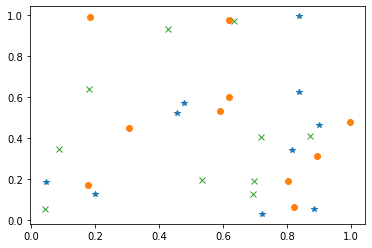

In [48]:
plt.plot(pts1[0], pts1[1], '*')
plt.plot(pts2[0], pts2[1], 'o')
plt.plot(pts3[0], pts3[1], 'x')

In [28]:
G = nx.Graph()

G.add_edges_from([('A','B'), ('B','C'), 
                  ('D','E'), ('E','F'),
                  ('A','D'), ('C','F'),
                  ('B','E'), ('B','F')])

GDV = graco.orbits(G)
GCV = graco.coefficients(G)

In [36]:
GDV[['0','1','2','3']]

Orbit,0,1,2,3
A,2,4,1,0
B,4,2,4,2
C,2,3,0,1
D,2,3,1,0
E,3,4,2,1
F,3,2,1,2


In [38]:
pd.DataFrame(graco.distance_matrix(GDV[['0','1','2','3']], 'GDV_similarity'))

,0,1,2,3,4,5
0,0.000000,0.268114,0.569367,0.533545,0.675803,0.629478
1,0.268114,0.000000,0.594447,0.586704,0.615602,0.640689
2,0.569367,0.594447,0.000000,0.605022,0.574584,0.499288
3,0.533545,0.586704,0.605022,0.000000,0.424585,0.437259
4,0.675803,0.615602,0.574584,0.424585,0.000000,0.399970
5,0.629478,0.640689,0.499288,0.437259,0.399970,0.000000


In [33]:
pd.DataFrame(graco.GCV_distance(GCV['D']['0'], 'canberra'))

,A,B,C,D,E,F
A,0.00,0.600000,1.00,0.00,0.600000,0.750000
B,0.60,0.000000,0.75,0.60,0.000000,0.333333
C,1.00,0.750000,0.00,1.00,0.750000,0.600000
D,0.00,0.600000,1.00,0.00,0.600000,0.750000
E,0.60,0.000000,0.75,0.60,0.000000,0.333333
F,0.75,0.333333,0.60,0.75,0.333333,0.000000


In [36]:
GCV['D']

Equation         0                   1                                  2  \
Orbit            2         3        10        12         5         8   11   
A         1.000000  0.000000  0.000000  0.000000  0.500000  0.500000  NaN   
B         0.666667  0.333333  0.166667  0.000000  0.500000  0.333333  0.5   
C         0.000000  1.000000  0.333333  0.666667  0.000000  0.000000  NaN   
D         1.000000  0.000000  0.000000  0.000000  0.333333  0.666667  NaN   
E         0.666667  0.333333  0.125000  0.250000  0.375000  0.250000  1.0   
F         0.333333  0.666667  0.750000  0.000000  0.250000  0.000000  0.0   

Equation                  3            
Orbit        13      7   11   13   14  
A           NaN    NaN  NaN  NaN  NaN  
B         0.125  0.375  0.5  0.5  0.0  
C           NaN    NaN  NaN  NaN  NaN  
D           NaN    NaN  NaN  NaN  NaN  
E         0.000  0.000  1.0  0.0  0.0  
F         1.000  0.000  0.0  1.0  0.0

In [73]:
{go_term.name for go_term in go_dag.values() if go_term.namespace == 'biological_process' and go_term.depth == 3 and go_term.level == 2}

{'Sertoli cell proliferation',
 'bud dormancy process',
 'cell adhesion involved in prostatic bud elongation',
 'cell motility',
 'cell-cell signaling',
 'detection of stimulus involved in meiotic spindle checkpoint',
 'egg activation',
 'epithelial cell proliferation involved in prostate gland development',
 'extracellular matrix-cell signaling',
 'growth involved in symbiotic interaction',
 'leukocyte activation',
 'maintenance of location',
 'meiotic cell cycle',
 'meiotic cell cycle process',
 'mesenchymal cell proliferation involved in prostate gland development',
 'morphogenesis of a branching structure',
 'motogenic signaling initiating cell movement in cerebral cortex',
 'motogenic signaling involved in interneuron migration from the subpallium to the cortex',
 'motogenic signaling involved in postnatal olfactory bulb interneuron migration',
 'movement in environment of other organism involved in symbiotic interaction',
 'multi organism cell adhesion',
 'multicellular organism 

In [23]:
[go_term.id for go_term in go_dag.values() if go_term.name == 'cell cycle']

['GO:0007049']

In [18]:
[go_term.name for go_term in go_dag['GO:0009566'].children if go_term.depth==2]

[]

In [24]:
go_dag['GO:0007049']

GOTerm('GO:0007049'):
  id:GO:0007049
  item_id:GO:0007049
  name:cell cycle
  namespace:biological_process
  _parents: 1 items
    GO:0009987
  parents: 1 items
    GO:0009987	level-01	depth-01	cellular process [biological_process]
  children: 2 items
    GO:0051321	level-02	depth-03	meiotic cell cycle [biological_process]
    GO:0000278	level-03	depth-03	mitotic cell cycle [biological_process]
  level:2
  depth:2
  is_obsolete:False
  alt_ids: 0 items

In [103]:
[[go_term.name for go_term in path] for path in go_dag.paths_to_top('GO:0051321')]

[['biological_process', 'reproductive process', 'meiotic cell cycle'],
 ['biological_process',
  'cellular process',
  'cell cycle',
  'meiotic cell cycle']]

In [72]:
go_id, = random.sample(go_dag.keys(),1)

level = go_dag[go_id].level
depth = go_dag[go_id].depth

In [73]:
level, depth

(4, 9)

In [74]:
sorted(len(path)-1 for path in go_dag.paths_to_top(go_id))

[4, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9]

In [39]:
G = nx.DiGraph()
G.add_edges_from(term.get_all_parent_edges())

In [40]:
go_dag['GO:0008150']

GOTerm('GO:0008150'):
  id:GO:0008150
  item_id:GO:0008150
  name:biological_process
  namespace:biological_process
  _parents: 0 items
  parents: 0 items
  children: 30 items
  level:0
  depth:0
  is_obsolete:False
  alt_ids: 3 items
    GO:0044699
    GO:0007582
    GO:0000004

In [41]:
nx.path_graph

<function networkx.generators.classic.path_graph(n, create_using=None)>

In [43]:
nx.shortest_path_length(G,'GO:0000001', 'GO:0008150')

5

In [36]:
G['GO:0000001']

AtlasView({'GO:0071840': {}, 'GO:0009987': {}, 'GO:0051179': {}})

# Network models

In [267]:
PPI_nx = nx.read_edgelist(f"{NETWORK_DIRECTORY}/PPI_BioGRID.txt")
PPI_GDV = graco.orbits(PPI_nx)
PPI_GCV = graco.coefficients(PPI_nx)

In [275]:
nx.density(PPI_nx)

0.005670724360040084

In [351]:
N = 2**12
p = 0.01

#G = nx.erdos_renyi_graph(N, p)
#G = nx.barabasi_albert_graph(N, 2)
#G = nx.random_geometric_graph(N, radius=0.64, dim=10)
G = nx.random_internet_as_graph(N)
print(nx.density(G))

GDV = graco.orbits(G)
GCV = graco.coefficients(G)

0.0009219513125763126


In [352]:
feature = pd.DataFrame({'x':GCV['D']['0']['3'],
                        'y':GCV['A']['0']['3']})

PPI_feature = pd.DataFrame({'x':PPI_GCV['D']['0']['3'],
                           'y':PPI_GCV['A']['0']['3']})

(0, 1)

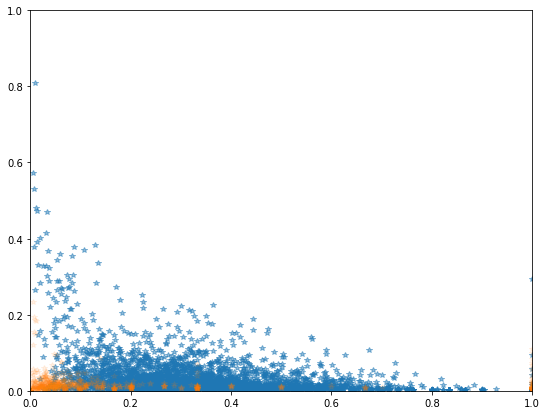

In [353]:
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(PPI_feature['x'], PPI_feature['y'], '*', alpha=0.5);
ax.plot(    feature['x'],     feature['y'], '*', alpha=0.1);
ax.set_xlim(0,1)
ax.set_ylim(0,1)

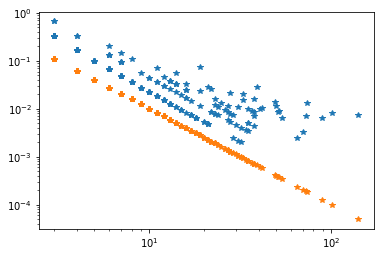

In [21]:
x = GDV['0']
y = GCV['D']['0']['3']

plt.loglog(x,y, '*');
plt.loglog(x,x.astype(float)**(-2), '*');

# Density calculation

In [57]:
@np.vectorize
def f_Z(t):
    return np.where(0<t<1, 1/np.sqrt(t)-1, 0)

@np.vectorize
def f_Z2(t):
    return quad(lambda tau:f_Z(t-tau)*f_Z(tau),0,2)[0]

def kernel(t, tau):
    return (1/np.sqrt(t-tau)-1)*(1/np.sqrt(tau)-1)

@np.vectorize
def f_ZZ2(t):
    return quad(lambda tau : kernel(t,tau), max(0,t-1), min(1,t))[0]

@np.vectorize
def f_Z3(t):
    return quad(lambda tau:f_ZZ2(t-tau)*f_Z(tau),0,3)[0]

In [58]:
X1 = np.random.uniform(size = 5000)
Y1 = np.random.uniform(size = 5000)

X2 = np.random.uniform(size = 5000)
Y2 = np.random.uniform(size = 5000)

X3 = np.random.uniform(size = 5000)
Y3 = np.random.uniform(size = 5000)

Z1 = np.abs(X1-Y1)**2
Z2 = np.abs(X2-Y2)**2
Z3 = np.abs(X2-Y2)**2

Z = Z1+Z2+Z3

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improv

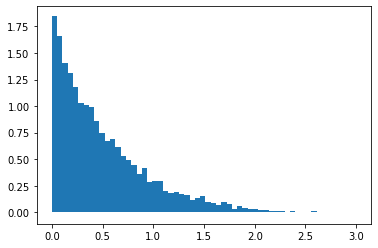

In [59]:
x = np.linspace(0,3,200)
y = f_Z3(x)

plt.hist(Z, bins=50, density=True);
plt.plot(x,y)

# Nan-control

In [4]:
feature = 'GDV'

MIN_CLUSTERS = 2
MAX_CLUSTERS = 100

all_distances = sorted('_'.join(filename.split('_')[:-1]) 
                           for filename in os.listdir(f"{MATRIX_DIRECTORY}/{feature}"))

In [5]:
for distance in all_distances:
    df = pd.read_csv(f"{MATRIX_DIRECTORY}/{feature}/{distance}_BioGRID.txt", delimiter=' ')
    print(distance, df.isna().any().any())

GDV_similarity False
braycurtis False
canberra False
chebyshev False
cityblock False
correlation False
cosine False
euclidean False
mahalanobis False
normalized1_l1 False
normalized1_l2 False
normalized1_linf False
normalized2_l1 False
normalized2_l2 False
normalized2_linf False
seuclidean False
sqeuclidean False


# Matrix preparation

In [228]:
G = nx.erdos_renyi_graph(100,0.1)
GDV = graco.orbits(G)
deg = GDV['0'].values

A = nx.to_numpy_array(G)
Asq = A@A
T = Asq*A

E = Asq-T
np.fill_diagonal(E,0)


B1 = A*(deg-1)-T
B2 = B1.T

In [229]:
(1*GDV['1']  + 2*GDV['3']                              == A@(GDV['0']-1)).all(), \
(1*GDV['4']  + 2*GDV['8']  + 2*GDV['9']  + 2*GDV['12'] == E@(GDV['0']-1)).all(), \
(1*GDV['10'] + 2*GDV['12'] + 6*GDV['14'] + 2*GDV['13'] == T@(GDV['0']-2)).all(), \
(2*GDV['6']  + 1*GDV['10'] + 2*GDV['9']  + 2*GDV['12'] == B1@(GDV['0']-2)).all(), \
(1*GDV['5']  + 2*GDV['11'] + 2*GDV['8']  + 2*GDV['13'] == B2@(GDV['0']-1)).all()

(True, True, True, True, True)

In [234]:
matrices = [A, Asq, T, E, B1, B2]

for i in range(4):
    D1 = np.diag(GDV[str(i)])
    D2 = D1*D1
    matrices.append(D1.copy())
    matrices.append(D2.copy())

# One matrix

In [235]:
for nr,M in enumerate(matrices):
    for tmp1 in range(4):
        GDV['tmp1'] = M @ GDV[str(tmp1)]
        for i in range(4):
            for comb in combinations(range(4),i):
                orbits = sorted(map(str,set(range(4)) - set(comb))) + ['tmp1']
                test = GDV[orbits]
                rank = np.linalg.matrix_rank(test)

                if rank == len(orbits)-1:
                    k = scipy.linalg.null_space(test)
                    assert k.shape == (len(orbits),1)
                    if (np.abs(k) < 1e-10).any():
                        continue
                    else:
                        print("YASS!!")
                        print(orbits, nr)

YASS!!
['0', '1', '3', 'tmp1'] 0
YASS!!
['0', '2', '3', 'tmp1'] 6


# Two matrices

In [240]:
name2matrix = {
    'A':A,
    'Asq':Asq,
    'T':T,
    'E':E,
    'B1':B1,
    'B2':B2,
    
    'D01': np.diag(GDV['0']),
    'D02': np.diag(GDV['0'])*np.diag(GDV['0']),
    
    'D11': np.diag(GDV['1']),
    'D12': np.diag(GDV['1'])*np.diag(GDV['1']),
    
    'D21': np.diag(GDV['2']),
    'D22': np.diag(GDV['2'])*np.diag(GDV['2']),
    
    'D31': np.diag(GDV['3']),
    'D32': np.diag(GDV['3'])*np.diag(GDV['3'])
}

In [244]:
for M_name, N_name in combinations_with_replacement(name2matrix, 2):
    M = name2matrix[M_name]
    N = name2matrix[N_name]
    for tmp1,tmp2 in product(range(4), repeat=2):
        GDV['tmp1'] = M @ GDV[str(tmp1)]
        GDV['tmp2'] = N @ GDV[str(tmp2)]
        for i in range(4):
            for comb in combinations(range(4),i):
                num_orbits = set(range(4)) - set(comb)
                orbits = sorted(map(str,num_orbits)) + ['tmp1', 'tmp2']
                test = GDV[orbits]
                rank = np.linalg.matrix_rank(test)

                if rank == len(orbits)-1:
                    k = scipy.linalg.null_space(test)
                    assert k.shape == (len(orbits),1)
                    if (np.abs(k) < 1e-10).any():
                        continue
                    else:
                        print(orbits, M_name, N_name)

YASS!!
['1', '2', 'tmp1', 'tmp2'] A D01


# Three matrices

In [245]:
for M_name, N_name, O_name in combinations_with_replacement(name2matrix, 3):
    M = name2matrix[M_name]
    N = name2matrix[N_name]
    O = name2matrix[O_name]
    for tmp1,tmp2,tmp3 in product(range(4), repeat=3):
        GDV['tmp1'] = M @ GDV[str(tmp1)]
        GDV['tmp2'] = N @ GDV[str(tmp2)]
        GDV['tmp3'] = O @ GDV[str(tmp3)]
        for i in range(4):
            for comb in combinations(range(4),i):
                num_orbits = set(range(4)) - set(comb)
                orbits = sorted(map(str,num_orbits)) + ['tmp1', 'tmp2']
                test = GDV[orbits]
                rank = np.linalg.matrix_rank(test)

                if rank == len(orbits)-1:
                    k = scipy.linalg.null_space(test)
                    assert k.shape == (len(orbits),1)
                    if (np.abs(k) < 1e-10).any():
                        continue
                    else:
                        print(orbits, M_name, N_name, O_name)

['1', '2', 'tmp1', 'tmp2'] A D01 D01
['1', '2', 'tmp1', 'tmp2'] A D01 D01
['1', '2', 'tmp1', 'tmp2'] A D01 D01
['1', '2', 'tmp1', 'tmp2'] A D01 D01
['1', '2', 'tmp1', 'tmp2'] A D01 D02
['1', '2', 'tmp1', 'tmp2'] A D01 D02
['1', '2', 'tmp1', 'tmp2'] A D01 D02
['1', '2', 'tmp1', 'tmp2'] A D01 D02
['1', '2', 'tmp1', 'tmp2'] A D01 D11
['1', '2', 'tmp1', 'tmp2'] A D01 D11
['1', '2', 'tmp1', 'tmp2'] A D01 D11
['1', '2', 'tmp1', 'tmp2'] A D01 D11
['1', '2', 'tmp1', 'tmp2'] A D01 D12
['1', '2', 'tmp1', 'tmp2'] A D01 D12
['1', '2', 'tmp1', 'tmp2'] A D01 D12
['1', '2', 'tmp1', 'tmp2'] A D01 D12
['1', '2', 'tmp1', 'tmp2'] A D01 D21
['1', '2', 'tmp1', 'tmp2'] A D01 D21
['1', '2', 'tmp1', 'tmp2'] A D01 D21
['1', '2', 'tmp1', 'tmp2'] A D01 D21
['1', '2', 'tmp1', 'tmp2'] A D01 D22
['1', '2', 'tmp1', 'tmp2'] A D01 D22
['1', '2', 'tmp1', 'tmp2'] A D01 D22
['1', '2', 'tmp1', 'tmp2'] A D01 D22
['1', '2', 'tmp1', 'tmp2'] A D01 D31
['1', '2', 'tmp1', 'tmp2'] A D01 D31
['1', '2', 'tmp1', 'tmp2'] A D01 D31
[

# Here we GO

In [210]:
G = nx.erdos_renyi_graph(100,0.1)
A = nx.to_numpy_array(G)
Asq = A@A
T = Asq*A
GDV = graco.orbits(G)
GCV = graco.coefficients(GDV).sort_index(axis=1)

In [214]:
for tmp1,tmp2 in product(range(4), repeat=2):
    print(tmp1,tmp2)
    GDV['tmp1'] = GDV['0'] * GDV[str(tmp1)]
    GDV['tmp2'] =     A    @ GDV[str(tmp2)]
    for i in range(15):
        for comb in combinations(range(15),i):
            orbits = sorted(map(str,set(range(15)) - set(comb))) + ['tmp1', 'tmp2']
            test = GDV[orbits]
            rank = np.linalg.matrix_rank(test)

            if rank == len(orbits)-1:
                k = scipy.linalg.null_space(test)
                assert k.shape == (len(orbits),1)
                if (np.abs(k) < 1e-10).any():
                    continue
                else:
                    print("YASS!!")
                    print(orbits)
        print(orbits)

0 0
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', '8', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', 'tmp1', 'tmp2']
['0', '1', '2', '3', 'tmp1', 'tmp2']
['0', '1', '2', 'tmp1', 'tmp2']
YASS!!
['1', '2', 'tmp1', 'tmp2']
['0', '1', 'tmp1', 'tmp2']
['0', 'tmp1', 'tmp2']
0 1
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1',

['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '11', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', '8', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', '7', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', '6', 'tmp1', 'tmp2']
YASS!!
['10', '11', '13', '4', '7', '8', 'tmp1', 'tmp2']
YASS!!
['10', '11', '2', '4', '7', '8', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', '5', 'tmp1', 'tmp2']
['0', '1', '2', '3', '4', 'tmp1', 'tmp2']
['0', '1', '2', '3', 'tmp1', 'tmp2']
['0', '1', '2', 'tmp1', 'tmp2']
['0', '1', 'tmp1', 'tmp2']
['0', 'tmp1', 'tmp2']
2 2
['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9', 'tmp1', 'tmp2']
['0', '1', '1

In [175]:
(k < 1e-10).any()

True

In [198]:
np.linalg.matrix_rank(test)

6

In [199]:
k = scipy.linalg.null_space(test)
k

array([[ 0.15911146],
       [-0.47733437],
       [-0.47733437],
       [-0.47733437],
       [-0.47733437],
       [-0.23866719],
       [ 0.07955573]])

In [197]:
k/np.min(np.abs(k))

array([[ 2.],
       [-6.],
       [-6.],
       [-6.],
       [-6.],
       [-3.],
       [ 1.]])

In [18]:
def GCV_distance(GCV, distance, nan='include'):
    
    D_all   = pd.DataFrame(0, index=GCV.index, columns=GCV.index)
    Divisor = pd.DataFrame(0, index=GCV.index, columns=GCV.index)
    
    if nan == 'include':
        if type(GCV.columns) == pd.MultiIndex:

            depth = len(GCV.columns.levels)

            for eq in set(GCV.columns.droplevel([depth-1])):
                length = len(GCV[eq].T)
                D_i = graco.distance_matrix(GCV[eq].dropna(), distance) / normalizer(distance,length)
                not_nan_indices = GCV.index[~GCV[eq].isna().any(axis=1)]

                D_all.loc[  not_nan_indices,not_nan_indices] += D_i
                Divisor.loc[not_nan_indices,not_nan_indices] += 1

            return D_all / Divisor
        else:
            raise Exception
    else:
        raise Exception

In [19]:
GCV_distance(GCV,distance)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.546662,0.278728,0.312038,0.318776,0.910682,1.000000,0.395820,0.261469,0.258253,...,0.130271,0.191960,1.000000,0.486911,0.420022,0.617866,0.359332,0.695477,0.292172,0.530189
1,0.546662,0.000000,0.609112,0.356087,0.424291,0.945403,1.000000,0.517375,0.673267,0.444966,...,0.591247,0.618546,1.000000,0.675544,0.234329,0.760536,0.347479,0.740316,0.699624,0.798842
2,0.278728,0.609112,0.000000,0.376703,0.295422,0.920661,1.000000,0.359531,0.265850,0.293491,...,0.292337,0.317255,1.000000,0.526278,0.500473,0.651297,0.432109,0.624525,0.380882,0.540324
3,0.312038,0.356087,0.376703,0.000000,0.422270,0.921715,1.000000,0.255613,0.472879,0.380698,...,0.353116,0.400215,1.000000,0.460595,0.231867,0.686361,0.140217,0.659041,0.496829,0.625969
4,0.318776,0.424291,0.295422,0.422270,0.000000,0.935371,1.000000,0.482207,0.400508,0.178048,...,0.367968,0.389677,1.000000,0.638497,0.377440,0.644794,0.430537,0.690700,0.473200,0.689358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.617866,0.760536,0.651297,0.686361,0.644794,0.593955,1.000000,0.684452,0.577154,0.622174,...,0.603379,0.566484,1.000000,0.831940,0.721193,0.000000,0.669261,0.449778,0.581041,0.803595
96,0.359332,0.347479,0.432109,0.140217,0.430537,0.912922,1.000000,0.347709,0.479510,0.419744,...,0.372337,0.419940,1.000000,0.485271,0.150776,0.669261,0.000000,0.671800,0.492776,0.644355
97,0.695477,0.740316,0.624525,0.659041,0.690700,0.743148,1.000000,0.552383,0.609760,0.692453,...,0.698045,0.680081,1.000000,0.796926,0.722936,0.449778,0.671800,0.000000,0.690186,0.798580
98,0.292172,0.699624,0.380882,0.496829,0.473200,0.870389,1.000000,0.510476,0.228832,0.443733,...,0.182362,0.174109,1.000000,0.627741,0.586374,0.581041,0.492776,0.690186,0.000000,0.509881


In [12]:
distance = 'normalized1_linf'

In [13]:
D_all   = pd.DataFrame(0, index=GCV.index, columns=GCV.index)
Divisor = pd.DataFrame(0, index=GCV.index, columns=GCV.index)

depth = len(GCV.columns.levels)

for eq in set(GCV.columns.droplevel([depth-1])):
    length = len(GCV[eq].T)
    D_i = graco.distance_matrix(GCV[eq].dropna(), distance) / normalizer(distance,length)
    not_nan_indices = GCV.index[~GCV[eq].isna().any(axis=1)]
    
    D_all.loc[  not_nan_indices,not_nan_indices] += D_i
    Divisor.loc[not_nan_indices,not_nan_indices] += 1

D = D_all / Divisor

In [14]:
D

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
2,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
gcv = GCV.droplevel(0,axis=1)
GCV.columns.levels[-2]

Index(['0', '0-0', '1', '1-1', '1-2', '2', '2-1', '3', '3-3'], dtype='object', name='Source')

In [23]:
GCV.columns.levels[0:2]

FrozenList([['A', 'D', 'G'], ['0', '0-0', '1', '1-1', '1-2', '2', '2-1', '3', '3-3']])

In [20]:
GCV.xs('0-0', axis=1, level=-2)

Order          A                   G          
Target         1         3         1         3
0       0.906250  0.093750  0.906250  0.093750
1       0.884615  0.115385  0.884615  0.115385
2       0.827957  0.172043  0.827957  0.172043
3       0.954545  0.045455  0.954545  0.045455
4       0.920000  0.080000  0.920000  0.080000
..           ...       ...       ...       ...
95      0.909910  0.090090  0.909910  0.090090
96      0.894737  0.105263  0.894737  0.105263
97      0.923664  0.076336  0.923664  0.076336
98      0.902439  0.097561  0.902439  0.097561
99      0.894737  0.105263  0.894737  0.105263

[100 rows x 4 columns]

In [28]:
? pd.IndexSlice

In [79]:
T = nx.Graph()
T.add_edges_from(('o',i) for i in range(4))
graco.orbits(T)

Orbit,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
o,4,0,6,0,0,0,0,4,0,0,0,0,0,0,0
0,1,3,0,0,0,0,3,0,0,0,0,0,0,0,0
1,1,3,0,0,0,0,3,0,0,0,0,0,0,0,0
2,1,3,0,0,0,0,3,0,0,0,0,0,0,0,0
3,1,3,0,0,0,0,3,0,0,0,0,0,0,0,0


In [80]:
T.add_edges_from([(0,1)])
graco.orbits(T)

Orbit,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
o,4,0,5,1,0,0,0,2,0,0,0,2,0,0,0
0,2,2,0,1,0,0,1,0,0,0,2,0,0,0,0
1,2,2,0,1,0,0,1,0,0,0,2,0,0,0,0
2,1,3,0,0,0,0,2,0,0,1,0,0,0,0,0
3,1,3,0,0,0,0,2,0,0,1,0,0,0,0,0


In [81]:
T.add_edges_from([(1,2)])
graco.orbits(T)

Orbit,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
o,4,0,4,2,0,0,0,1,0,0,0,2,0,1,0
0,2,3,0,1,0,0,1,0,0,0,1,0,1,0,0
1,3,1,1,2,0,0,0,0,0,0,2,0,0,1,0
2,2,3,0,1,0,0,1,0,0,0,1,0,1,0,0
3,1,3,0,0,0,0,1,0,0,2,0,0,0,0,0


In [82]:
T.add_edges_from([(0,3)])
graco.orbits(T)

Orbit,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
o,4,0,3,3,0,0,0,0,0,0,0,2,0,2,0
0,3,2,1,2,0,1,0,0,0,0,1,0,1,1,0
1,3,2,1,2,0,1,0,0,0,0,1,0,1,1,0
2,2,3,0,1,1,0,0,0,0,1,1,0,1,0,0
3,2,3,0,1,1,0,0,0,0,1,1,0,1,0,0


In [43]:
nan_indices     = GCV.index[ GCV[eq].isna().any(axis=1)]
not_nan_indices = GCV.index[~GCV[eq].isna().any(axis=1)]
Divisor.loc[not_nan_indices,not_nan_indices] += 1

In [134]:
multi = GCV.columns
depth = len(GCV.columns.levels)
set(GCV.columns.droplevel([depth-1]))

In [135]:
set(GCV.columns.droplevel([depth-1]))

{('A', '0-0'),
 ('A', '1-2'),
 ('A', '2-1'),
 ('A', '3-3'),
 ('D', '0'),
 ('D', '1'),
 ('D', '2'),
 ('D', '3'),
 ('G', '0-0'),
 ('G', '1-1'),
 ('G', '1-2'),
 ('G', '2-1'),
 ('G', '3-3')}

In [77]:
GCV

Order     D                                              ...    G            \
Source    0         1                   2             3  ...  1-2       2-1   
Target    2    3    5    8   10   12    7   11   13  11  ...   10   12    5   
0       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
1       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
2       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
3       1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0 NaN  ...  0.0  0.0  1.0   
4       NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
..      ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ...  ...  ...  ...   
95      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  0.0  0.0  NaN   
96      1.0  0.0  1.0  0.0  0.0  0.0  NaN  NaN  NaN NaN  ...  0.0  0.0  1.0   
97      1.0  0.0  1.0  0.0  0.0  0.0  NaN  NaN  NaN NaN  ...  0.0  0.0  1.0   
98      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  ...  NaN  NaN  NaN   
99      1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0 NaN  ...  0.0  0.0  1.0   

Order                                  
Source                3-3              
Target    8   11   13  10  12  13  14  
0       NaN  NaN  NaN NaN NaN NaN NaN  
1       NaN  NaN  NaN NaN NaN NaN NaN  
2       NaN  NaN  NaN NaN NaN NaN NaN  
3       0.0  0.0  0.0 NaN NaN NaN NaN  
4       NaN  NaN  NaN NaN NaN NaN NaN  
..      ...  ...  ...  ..  ..  ..  ..  
95      NaN  NaN  NaN NaN NaN NaN NaN  
96      0.0  0.0  0.0 NaN NaN NaN NaN  
97      0.0  0.0  0.0 NaN NaN NaN NaN  
98      NaN  NaN  NaN NaN NaN NaN NaN  
99      0.0  0.0  0.0 NaN NaN NaN NaN  

[100 rows x 42 columns]

In [69]:
GCV[a[-2:]]

/home/clusterduck123/Desktop/git/supplements/venv/graco/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


KeyError: '0'

In [58]:
for b in product(*gcv.columns.levels[:-1]):
    break

In [59]:
b

('0',)

In [6]:
gcv = GCV_distance(GCV, 3)

In [7]:
distance = 'normalized1_linf'

In [23]:
D = pd.DataFrame(0, index=gcv.index, columns=gcv.index)

for group in gcv.columns.levels[0]:
    D = graco.distance_matrix(gcv[group], distance)
    break

In [24]:
D = pd.DataFrame(0, index=gcv.index, columns=gcv.index)
D

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
type(D.columns) == pd.MultiIndex

False

In [39]:
pd.MultiIndex.from_product([D.columns, ['C']])

MultiIndex([( 0, 'C'),
            ( 1, 'C'),
            ( 2, 'C'),
            ( 3, 'C'),
            ( 4, 'C'),
            ( 5, 'C'),
            ( 6, 'C'),
            ( 7, 'C'),
            ( 8, 'C'),
            ( 9, 'C'),
            (10, 'C'),
            (11, 'C'),
            (12, 'C'),
            (13, 'C'),
            (14, 'C'),
            (15, 'C'),
            (16, 'C'),
            (17, 'C'),
            (18, 'C'),
            (19, 'C'),
            (20, 'C'),
            (21, 'C'),
            (22, 'C'),
            (23, 'C'),
            (24, 'C'),
            (25, 'C'),
            (26, 'C'),
            (27, 'C'),
            (28, 'C'),
            (29, 'C'),
            (30, 'C'),
            (31, 'C'),
            (32, 'C'),
            (33, 'C'),
            (34, 'C'),
            (35, 'C'),
            (36, 'C'),
            (37, 'C'),
            (38, 'C'),
            (39, 'C'),
            (40, 'C'),
            (41, 'C'),
            (42, 'C'),
           

In [29]:
type(D.columns)

pandas.core.indexes.numeric.Int64Index

In [34]:
GCV.columns.droplevel([0,2])

Index(['0', '0', '1', '1', '1', '1', '2', '2', '2', '3', '3', '3', '0-0',
       '0-0', '2-1', '2-1', '2-1', '2-1', '1-2', '1-2', '1-2', '3-3', '3-3',
       '3-3', '0-0', '0-0', '1-1', '1-1', '1-1', '1-1', '1-2', '1-2', '1-2',
       '1-2', '2-1', '2-1', '2-1', '2-1', '3-3', '3-3', '3-3', '3-3'],
      dtype='object', name='Source')

In [22]:
range(-3)

range(0, -3)